In [21]:
from alphatoe import models, plot, interpretability, game
import pandas as pd
import torch
from pytorch_memlab import LineProfiler, MemReporter
from showmethetypes import SMTT
import einops
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [2]:
tt = SMTT("torch")

In [3]:
model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control-20230718-185339"
)

In [4]:
games = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")
games.head()

/tmp/ipykernel_37588/629368561.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  games = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")


,moves played,steps till end state,winner,rotation 1,rotation 2,rotation 3,horizontal flip,vertical flip,training index,train or test,first win condition,second win condition,end move loss
0,"[0, 1, 3, 2, 6]",5,X,399,1439,1040,1114,325,241912,test,left column,NaN,0.000005
1,"[0, 1, 3, 4, 6]",5,X,396,1438,1043,1112,327,190522,train,left column,NaN,0.000114
2,"[0, 1, 3, 5, 6]",5,X,398,1437,1041,1113,326,90275,train,left column,NaN,0.000007
3,"[0, 1, 3, 7, 6]",5,X,395,1436,1044,1110,329,21994,train,left column,NaN,0.000008
4,"[0, 1, 3, 8, 6]",5,X,397,1435,1042,1111,328,48696,train,left column,NaN,0.000013


- Sort games by game length [X]
- batch inference for games of length [X]
- extract activations with hooks [X]
- train autoencoder on data reconstruction (anthropic has tips here) [X]
- find good metrics + start looking at data (anthropic has tips here)

In [5]:
all_games = game.generate_all_games([game.Board()])

In [6]:
len(all_games)

255168

In [7]:
games_len_dict = {5: [], 6: [], 7: [], 8: [], 9: []}
for game in all_games:
    games_len_dict[len(game.moves_played)].append(game.moves_played)

In [8]:
s = 0
for key in games_len_dict.keys():
    s += len(games_len_dict[key])
print(s)

255168


In [9]:
games_len_tensors = {}
for key in games_len_dict.keys():
    games_len_tensors[key] = torch.stack(
        [torch.tensor([10] + game) for game in games_len_dict[key]]
    )

In [10]:
games_len_tensors[9].device

device(type='cpu')

In [11]:
# Activation hook
def neuron_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result

    try:
        with torch.inference_mode():
            handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
            _ = model(seq)
            activations = model.blocks[0].mlp.hook_post.captured_activations
            handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations

In [12]:
# a = neuron_activations(games_len_tensors[5])[:, -1]

In [13]:
# a.numel() * a.element_size()

In [14]:
# b = neuron_activations(games_len_tensors[9])
# reporter = MemReporter()
# reporter.report()

In [15]:
torch.cuda.empty_cache()

In [16]:
# Inference loop
# will there be a difference across game lengths?
# Doesn't fit in memory?
# 512 neurons * 255168 games * 32 bit floats * 10 seq len = 5.22 gigabytes???
all_acts = []
for i, key in enumerate(games_len_tensors.keys()):
    print(i)
    acts = neuron_activations(games_len_tensors[key])
    all_acts.append(acts)
    torch.cuda.empty_cache()

0
1
2
3
4


In [17]:
reporter = MemReporter()
reporter.report()

Element type                                            Size  Used MEM
-------------------------------------------------------------------------------
Storage on cpu
Tensor0                                         (127872, 10)     9.76M
Tensor1                                            (1440, 6)    67.50K
Tensor2                                            (5328, 7)   291.50K
Tensor3                                           (47952, 8)     2.93M
Tensor4                                           (72576, 9)     4.98M
-------------------------------------------------------------------------------
Total Tensors: 2361456 	Used Memory: 18.02M
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Storage on cuda:0
Tensor5                                       (1440, 6, 512)    16.88M
Tensor6                                       (5328, 7, 512)    72.84M
Tensor7                            

/home/thetis/.local/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


In [18]:
games_len_tensors[9].device

device(type='cpu')

In [19]:
tt(all_acts)

list (5)
    |__Tensor (dtype: torch.float32)
        |  (device: cuda:0)
        |__dim_0 (1440)
        |__dim_1 (6)
        |__dim_2 (512)


In [20]:
act_data = torch.

SyntaxError: invalid syntax (3397314265.py, line 1)

In [ ]:
act_data = torch.cat(
    [einops.rearrange(acts, "batch seq dim -> (batch seq) dim") for acts in all_acts],
    dim=0,
)

In [ ]:
torch.save(act_data, "all_games_act_data.pt")

Note that since there's a lot of repeated phrases in the input, we'll have lots of identical activations. Not sure how that'll change things yet though..

In [ ]:
tt(act_data)

Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (6393600)
    |__dim_1 (512)


In [ ]:
assert False

In [ ]:
autoenc = models.SparseAutoEncoder(512, 1024).to("cuda")

In [ ]:
loss_fn = torch.nn.functional.mse_loss
optimizer = torch.optim.Adam(autoenc.parameters(), lr=1e-4, weight_decay=0)

In [ ]:
act_data = torch.load("all_games_act_data.pt")

In [ ]:
tt(act_data)

Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (2361456)
    |__dim_1 (512)


In [ ]:
epochs = 10
batch_size = 2**15
lam = 1e-3
losses = []
for epoch in range(epochs):
    for batch in range(0, act_data.shape[0], batch_size):
        dat = act_data[batch : batch + batch_size].to("cuda")
        reg, guess = autoenc(dat)
        loss = loss_fn(guess, dat) + lam * reg
        losses.append(interpretability.numpy(loss))
        optimizer.zero_grad()
        loss.backward()
        print(loss)
        optimizer.step()

tensor(141820.3281, device='cuda:0', grad_fn=<AddBackward0>)
tensor(133590.7812, device='cuda:0', grad_fn=<AddBackward0>)
tensor(126669.7578, device='cuda:0', grad_fn=<AddBackward0>)
tensor(120385.2344, device='cuda:0', grad_fn=<AddBackward0>)
tensor(114468.9766, device='cuda:0', grad_fn=<AddBackward0>)
tensor(105951.7344, device='cuda:0', grad_fn=<AddBackward0>)
tensor(101364.9141, device='cuda:0', grad_fn=<AddBackward0>)
tensor(96357.5859, device='cuda:0', grad_fn=<AddBackward0>)
tensor(89067.0625, device='cuda:0', grad_fn=<AddBackward0>)
tensor(83257.0703, device='cuda:0', grad_fn=<AddBackward0>)
tensor(79895.8672, device='cuda:0', grad_fn=<AddBackward0>)
tensor(77020.7656, device='cuda:0', grad_fn=<AddBackward0>)
tensor(73950.6797, device='cuda:0', grad_fn=<AddBackward0>)
tensor(68036.5781, device='cuda:0', grad_fn=<AddBackward0>)
tensor(63056.1641, device='cuda:0', grad_fn=<AddBackward0>)
tensor(60387.9023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(56374.9258, device='cuda:0

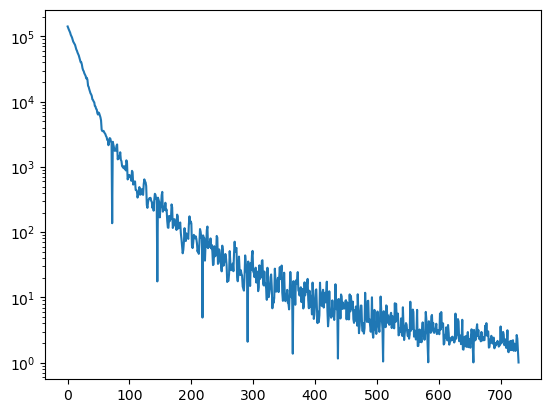

In [ ]:
plt.yscale("log")
plt.plot(range(len(losses)), losses)

Great. Now we've got an autoencoder, what do we do with it?

In [ ]:
@torch.no_grad()
def get_freqs(num_batches=25, local_encoder=None):
    if local_encoder is None:
        local_encoder = encoder
    act_freq_scores = torch.zeros(
        local_encoder.W_in.shape[1], dtype=torch.float32
    ).cuda()
    total = 0
    for i in tqdm.trange(num_batches):
        tokens = act_data[torch.randperm(len(act_data))][: 2**14]

        hidden = local_encoder.get_act_density(tokens)

        act_freq_scores += hidden
        total += hidden.shape[0]
    act_freq_scores /= total
    num_dead = (act_freq_scores == 0).float().mean()
    print("Num dead", num_dead)
    return act_freq_scores

In [ ]:
freqs = get_freqs(local_encoder=autoenc)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 43.34it/s]

Num dead tensor(0.6191, device='cuda:0')


In [ ]:
tt(freqs)

Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (1024)


/tmp/ipykernel_88767/2885543625.py:1: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(interpretability.numpy(freqs))


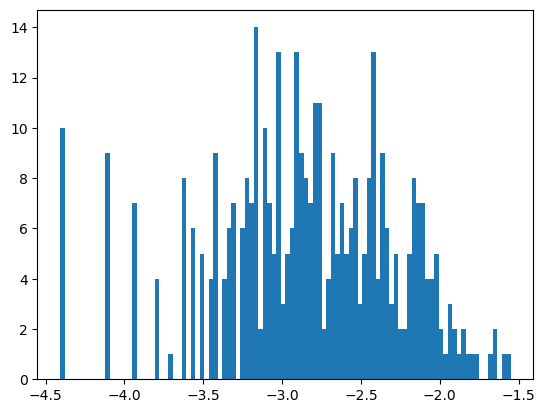

In [ ]:
x = np.log10(interpretability.numpy(freqs))
# x = interpretability.numpy(freqs)
x = x[np.isfinite(x)]
plt.hist(x, bins=100)

In [ ]:
print(1e-4)

0.0001
